In [45]:
include(joinpath(pwd(), "MPC_functions.jl"))
using  Luna
import FFTW                    
import Luna: Hankel  
import NumericalIntegration: integrate, SimpsonEven          
import Dates                   
using LaTeXStrings
using Printf
using DSP
using HDF5
using PyPlot
pygui(true)
using Plots
using CSV
using DataFrames


In [46]:
PyPlot.rcdefaults() # reset to default
PyPlot.close("all")

# Set global plotting parameters for PyPlot.jl
PyPlot.rc("font", size=12)      #family="serif",
# PyPlot.rc("axes", titlesize=18, labelsize=16)
# PyPlot.rc("xtick", labelsize=12)
# PyPlot.rc("ytick", labelsize=12)
PyPlot.rc("lines", linewidth=1.5)
size_py = 0.393701*[20, 15]     # figure size
size_py_wide = 0.393701*[20, 8]# figure size in cm
size_py_small = 0.393701*[20, 10]     # figure size

res = 300                       # figure resolution (dpi)

300

In [47]:
# Set global plotting parameters for Plots.jl
default(
#       guidefont = font(16, "Times"),    # Axis label font
#       tickfont = font(14),              # Axis tick font
#       legendfontsize = 12,              # Legend font size
#       titlefont = font(18, "Arial"),    # Title font
        linewidth=2
  )
size_jl=(800,600)   # figure size in pixel
# closeall()


(800, 600)

In [48]:
out_path = joinpath(pwd(), "..", "..", "thesis")
save_figs = false


false

## READ IN RESULTS FROM ESMERANDOS 1D CODE

In [49]:
using DelimitedFiles

# Reading results from Esmerandos script
dir_path = joinpath("output_thesis", "2025-07-23_14-53-30")

#spectrum
file = joinpath(dir_path, "output_spectrum.txt")
data = readdlm(file, '\t', skipstart=1)
λ_esm = data[:,1].*1e-9   
Iλ_esm = data[:,2]
ϕω_esm = data[:,3]

# pulse temporal
file = joinpath(dir_path, "output_pulse.txt")
data = readdlm(file, '\t', skipstart=1) 
t_esm = data[:,1]
It_esm = data[:,2] 
ϕt_esm = data[:,3]

8192-element Vector{Float64}:
  1.93365062784208
  1.95936764165217
  1.98935359316182
  2.02405366450764
  2.0638267029205
  2.10903497130083
  2.16008121346321
  2.21714747365044
  2.28038460535939
  2.34963512541382
  ⋮
 33.2613795285699
 33.2612171298789
 33.2631485844057
 33.2672791473716
 33.2738070084248
 33.2828706591521
 33.2947438235813
 33.3096192592227
 33.3277887226596

## PAPER DATA

In [50]:
df = CSV.read(joinpath("input", "paper_caus_3.0_Xe.csv"), DataFrame)
z_caus = df[:,1]
caus = df[:,2]

df = CSV.read(joinpath("input", "paper_spec_3.0_Xe.csv"), DataFrame)
lamb = df[:,1]
spec = df[:,2]

println(caus[1])

0.5469130378243092


## I) Read data from .h5 file

In [51]:
run = "run_2025_08_03__21_30_38"
run_path = joinpath("output", run)

params = Dict()

# Open file read-only
h5open(joinpath(run_path, "output.h5"), "r") do file
    # List datasets/groups in the file
    println(keys(file))
    
    # Read dataset
    global Eωr0 = read(file["Eωr0"])
    global Eωr_in = read(file["Eωr_in"])
    global Eωr_out = read(file["Eωr_out"])

    # Read beam waists
    global w_z = read(file["w_z"]) 
    global w_min = read(file["w_min"]) 
    global w_mirr = read(file["w_mirr"]) 
    
    global ω = read(file["ω"])
    global t = read(file["t"])
    global r = read(file["r"])
    global z = read(file["z"])

    # file["params"] is a group with keys as parameter names
    param_group = file["params"]
    for name in keys(param_group)
        params[name] = read(param_group[name])
    end
end

["Eωr0", "Eωr_in", "Eωr_out", "params", "r", "t", "w_min", "w_mirr", "w_z", "z", "ω"]


Regenerate Hankel transform matrix "q", simulation grid as well as additional coordinate axes rsym, f and λ

In [52]:
q = Hankel.QDHT(params["R_Hankel"], params["N_Hankel"], dim=2)                  # set up discrete Hankel transform matrix, transformation done along 2nd dimension 
q_1D = Hankel.QDHT(params["R_Hankel"], params["N_Hankel"], dim=1)               # to be applied to arrays that where integrated over ω, so r becomes 1rst dimension
rsym = Hankel.Rsymmetric(q)                                 # sampled radii [m] mirrored around and including r=0 so that rsym = [–rn, ...-r2, -r1, 0, r1, r2, ..., rn]

L = params["L"]
λ0 = params["λ0"]
λlims = (params["λmin"], params["λmax"])
trange_request = params["trange_request"]

grid = Grid.RealGrid(L, λ0, λlims, trange_request)               # set up time & space grid for gradient approximation
f = ω./2π                      # sampled linear frequencies [Hz]
λ = PhysData.wlfreq.(ω)         # sampled wavelengths [m]
λ[1] = 1.0                        # avoid "Inf" value for DC frequency

┌ Info: Freq limits 0.25 - 0.33 PHz
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:40
┌ Info: Samples needed: 3497.58, samples: 4096, δt = 500.35 as
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:44
┌ Info: Requested time window: 1750.0 fs, actual time window: 2049.4 fs
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:46
┌ Info: Grid: samples 2048 / 4096, ωmax 3.14e+15 / 6.28e+15
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:78


1.0

## II) Analyze final output (last propagation step of last pass)

### a) Input vs. output spectrum and spectral phase

In [53]:
Eωr0_in = Eωr0[:,1,1]
Eωr0_out = Eωr0[:,end,end]

1025-element Vector{ComplexF64}:
 -0.005202753466659641 + 0.0im
 0.0028382847739540497 - 0.00435604027215016im
 0.0020860713459684025 + 0.004752908315371751im
 -0.005111954345641239 - 0.0008668271364432228im
  0.003540911866714313 - 0.0037949399288445614im
 0.0012267321025898695 + 0.005068272090855455im
 -0.004936832496404451 - 0.0017637279330526923im
  0.004201953391336639 - 0.0031875761280167436im
  0.000378075469404938 + 0.005281069426360429im
 -0.004639111639991687 - 0.0025783721162625484im
                       ⋮
   0.17211004151231227 - 0.15810924055259928im
   0.03710783412384305 + 0.22990955441387295im
  -0.21083857000434675 - 0.09508638004192281im
   0.19434816984900405 - 0.12182398965460148im
 -0.007099417497983402 + 0.22781890428820367im
  -0.18468655905605358 - 0.13287259102699284im
   0.21370292973305305 - 0.07963220684599787im
   -0.0521226641629089 + 0.2228896670894054im
  -0.15759389875552837 - 0.16655278568209442im

In [54]:
ϕω_in = unwrap_phase(ω, t, Eωr0_in)
ϕω_out = unwrap_phase(ω, t, Eωr0_out)

ϕω_in = blank_phase(ω, abs2.(Eωr0_in), ϕω_in; level=0.05)
ϕω_out = blank_phase(ω, abs2.(Eωr0_out), ϕω_out; level=0.05)

1025-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

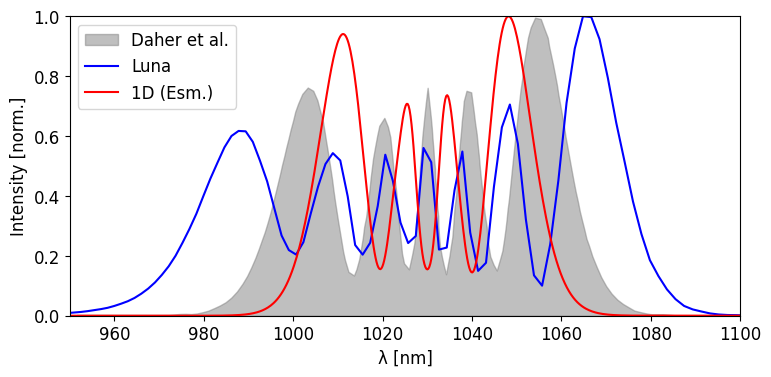

In [55]:
plt.figure(figsize=size_py_small)
# plt.title("Output spectrum comparison")
plt.fill_between(lamb, spec, label="Daher et al.", alpha=0.5, color="grey")
plt.plot(λ.*1e9, Maths.normbymax(abs2.(Eωr0_out)), label="Luna", color="blue")#, alpha=0.5)
plt.plot(λ_esm.*1e9, Maths.normbymax(Iλ_esm), label="1D (Esm.)", color="red")#, alpha=0.5)
plt.xlim(950, 1100)
plt.ylim(0, 1)
# plt.xlim(980, 1080)#λlims[1]*1e9, λlims[2]*1e9)
plt.xlabel("λ [nm]")
plt.ylabel("Intensity [norm.]")
plt.legend(loc="upper left")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(out_path, "spec_3.0_Xe_comp.png"), dpi=res) 
end
plt.gcf()

### b) Input vs. output pulse

In [56]:
Etr0_in = Maths.hilbert(FFTW.irfft(Eωr0_in, length(t), 1))
Etr0_out = Maths.hilbert(FFTW.irfft(Eωr0_out, length(t), 1))

ϕt_in = unwrap(angle.(Etr0_in))
ϕt_out = unwrap(angle.(Etr0_out))

ϕt_in = blank_phase(t, abs2.(Etr0_in), ϕt_in; level=0.05)
ϕt_out = blank_phase(t, abs2.(Etr0_out), ϕt_out; level=0.05)

2048-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

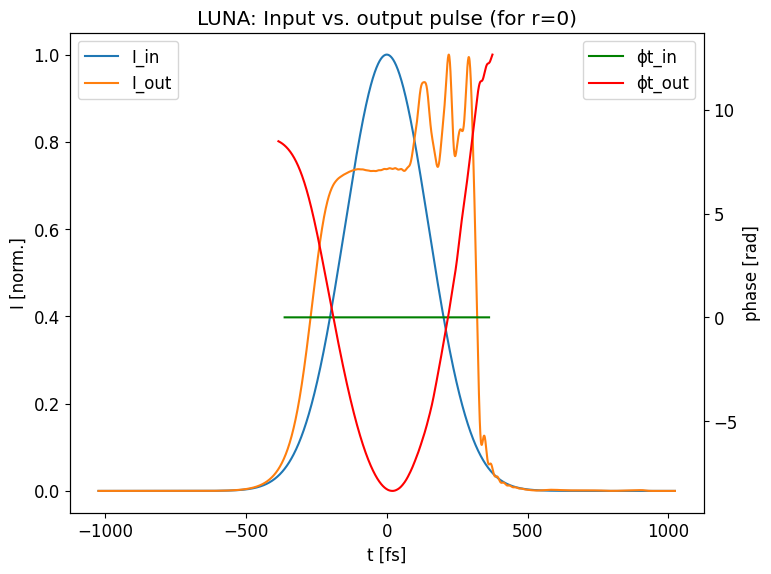

In [57]:
fig, ax1 = plt.subplots(figsize=size_py)
ax1.set_title("LUNA: Input vs. output pulse (for r=0)")
ax1.plot(t.*1e15, Maths.normbymax(abs2.(Etr0_in)), label="I_in")
ax1.plot(t.*1e15, Maths.normbymax(abs2.(Etr0_out)), label="I_out")
ax2 = ax1.twinx()
ax2.plot(t.*1e15, detrend(ϕt_in), label="ϕt_in", color="green")
ax2.plot(t.*1e15, detrend(ϕt_out), label="ϕt_out", color="red")
# ax1.set_xlim(-200, 200)
ax1.set_xlabel("t [fs]")
ax1.set_ylabel("I [norm.]")
ax2.set_ylabel("phase [rad]")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "pulse_in_vs_out.png"), dpi=res) 
end
plt.gcf()

### c) Spectral homogeinity across r

In [58]:
Irλ_out = transpose(Iwlfreq.(ω, abs2.(Eωr_out)))

256×1025 transpose(::Matrix{Float64}) with eltype Float64:
 0.0  1.26142e11  5.02762e11  …  2.45385e20  2.47803e20  2.49184e20
 0.0  9.59183e10  3.81909e11     1.585e20    1.60376e20  1.61404e20
 0.0  6.07912e10  2.41725e11     6.72934e19  6.83435e19  6.88982e19
 0.0  3.19351e10  1.26731e11     1.40124e19  1.42946e19  1.44474e19
 0.0  1.12238e10  4.42524e10     2.88849e17  8.47147e16  3.72219e14
 0.0  6.85676e8   2.55609e9   …  7.88887e18  7.41e18     7.2089e18
 0.0  2.07558e9   8.6837e9       1.71174e19  1.64867e19  1.62335e19
 0.0  5.66495e9   2.33276e10     1.35281e19  1.29676e19  1.27443e19
 0.0  1.22794e9   5.23372e9      1.29756e18  1.13002e18  1.06101e18
 0.0  4.31332e9   1.67762e10     8.47466e18  8.91034e18  9.11127e18
 ⋮                            ⋱                          
 0.0  3.61606e7   1.45044e8      4.00361e17  4.00334e17  4.00809e17
 0.0  7.33514e8   2.93873e9      2.18029e18  2.18000e18  2.18266e18
 0.0  1.59511e9   6.38994e9      3.74794e18  3.74729e18  3.75187e18


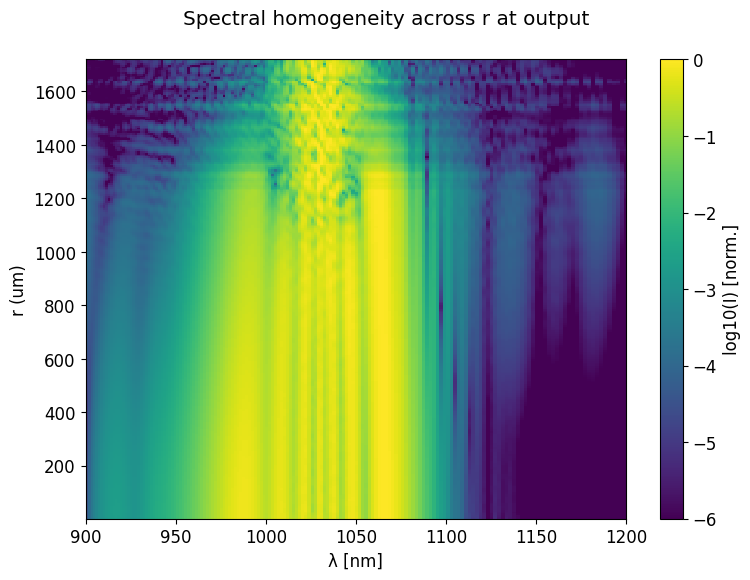

In [59]:
smallval = 1e-50

plt.figure(figsize=size_py)
plt.suptitle("Spectral homogeneity across r at output")
plt.pcolormesh(λ*1e9, r*1e6, Maths.log10_norm(Irλ_out .+smallval, 2))   
plt.clim(-6, 0)    
plt.colorbar(label="log10(I) [norm.]")
plt.xlim(λlims[1]*1e9, λlims[2]*1e9)
plt.xlabel("λ [nm]")
plt.ylabel("r (um)") 
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spectral_homogeneity.png"), dpi=res) 
end
plt.gcf()

### d) Spatiotemporal profile

In [60]:
Etr_out = Maths.hilbert(FFTW.irfft(Eωr_out, length(t), 1))

2048×256 Matrix{ComplexF64}:
 -3.65841-2.70483im     -1.83758-2.56601im   …    0.075002+0.123226im
  4.42405-0.917567im     3.10684+0.334707im      -0.140488-0.027028im
 -2.24756+3.86782im     -2.29875+2.05884im        0.113815-0.0857409im
  -1.3554-4.22245im    0.0178639-3.06059im      -0.0120924+0.141372im
  4.02201+1.80537im      2.25351+2.05008im      -0.0964973-0.102553im
 -3.99813+1.78157im     -3.00567+0.314014im  …    0.139637-0.00306784im
  1.32927-4.12418im      1.75348-2.41749im      -0.0906351+0.105159im
  2.15208+3.71695im     0.610748+2.89651im      -0.0176266-0.136855im
 -4.17955-0.883586im     -2.5496-1.47604im        0.112678+0.0776787im
   3.4241-2.51097im      2.77806-0.913095im      -0.132119+0.0313705im
         ⋮                                   ⋱            ⋮
 -1.51242+4.8381im      -2.08974+2.66805im       0.0976989-0.121452im
 -2.48608-4.18909im    -0.614135-3.34457im   …   0.0216778+0.149505im
  4.65211+0.996813im     2.89155+1.73754im       -0.122639-0.08541

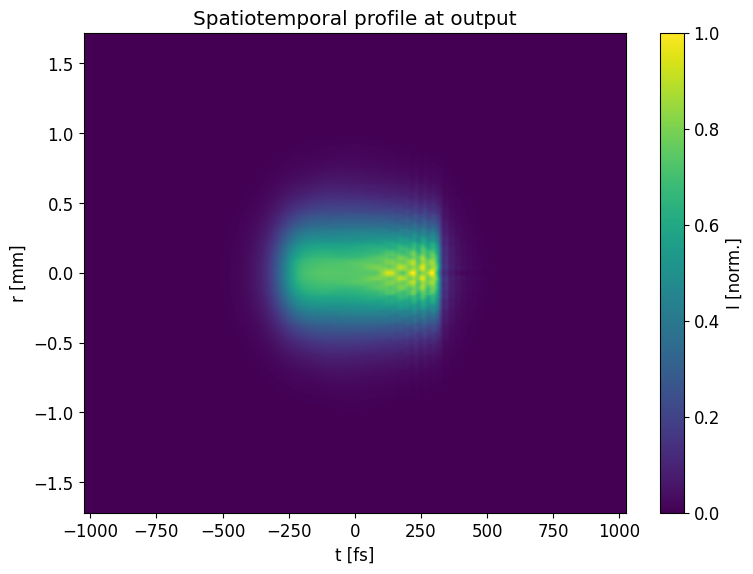

In [61]:
plt.figure(figsize=size_py) 
plt.title("Spatiotemporal profile at output")
plt.pcolormesh(t.*1e15, rsym.*1e3, Maths.normbymax(abs2.(Hankel.symmetric(Etr_out, q)')))
plt.colorbar(label="I [norm.]")
plt.xlabel("t [fs]")
plt.ylabel("r [mm]")
# plt.ylim(minimum(rsym*1e3), maximum(rsym*1e3))
# plt.xlim(minimum(t*1e15)/2, maximum(t*1e15)/2)
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spatiotemporal_profile.png"), dpi=res) 
end
plt.gcf()

## III) Analyze overall pulse evolution across all passes

In [62]:
Nω = size(Eωr_in,1)
Nr = size(Eωr_in,2)
Nz = size(Eωr0,2)
Npass = size(Eωr0,3)

Nt = length(t)
Nrsym = length(rsym)

513

In [63]:
z_total = zeros(Nz, Npass)

for pass in 1:Npass 
    z_total[:,pass] = z .+ (pass-1)*z[end]
end

z_total = vcat(z_total...)

2010-element Vector{Float64}:
 0.0
 0.002755
 0.00551
 0.008265
 0.01102
 0.013775
 0.01653
 0.019285
 0.02204
 0.024795
 ⋮
 5.48796
 5.490715000000001
 5.49347
 5.496225000000001
 5.49898
 5.501735
 5.5044900000000005
 5.507245
 5.510000000000001

### a) Beams Caustic 

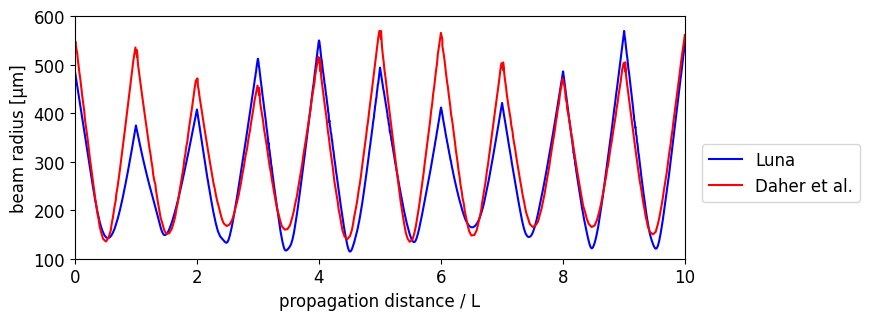

In [64]:
# PLOT CAUSTIC
plt.figure(figsize=size_py_wide) 
# plt.title("Caustic")
plt.plot(z_total./L, w_z.*1e6, label="Luna", linestyle="-", color="blue", linewidth=1.5)

plt.plot(z_caus./L, caus.*1e3, label="Daher et al.", color="red", linewidth=1.5)
plt.xlabel("propagation distance / L")
plt.ylabel("beam radius [μm]")
# plt.xlim(0,maximum(z_total.*1e2))
plt.xlim(0,10)
plt.ylim(100, 600)
plt.legend(loc="lower right", bbox_to_anchor=(1.30, 0.2))
# plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(out_path, "caus_3.0_Xe_comp.png"), bbox_inches="tight", dpi=res) 
end
plt.gcf()

<!-- ### b) Minimum beam waist per pass -->

In [65]:
println(caus[1]*1e6)
println(w_z[1]*1e6)

546913.0378243092
486.70040821396253


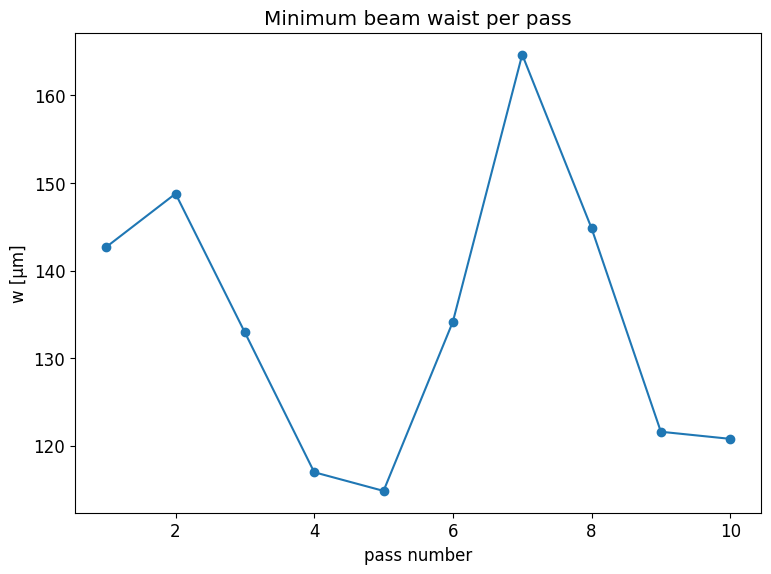

In [66]:
# PLOT minimum beam waist per pass
plt.figure(figsize=size_py) 
plt.title("Minimum beam waist per pass")
plt.plot(1:Npass, w_min.*1e6, marker="o")
#plt.xticks(0:5:Npass)
plt.xlabel("pass number")
plt.ylabel("w [μm]")
# plt.ylim(95,125)
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "beam_waist_minimum.png"), dpi=res) 
end
plt.gcf()

### c) Mirror beam waist per pass

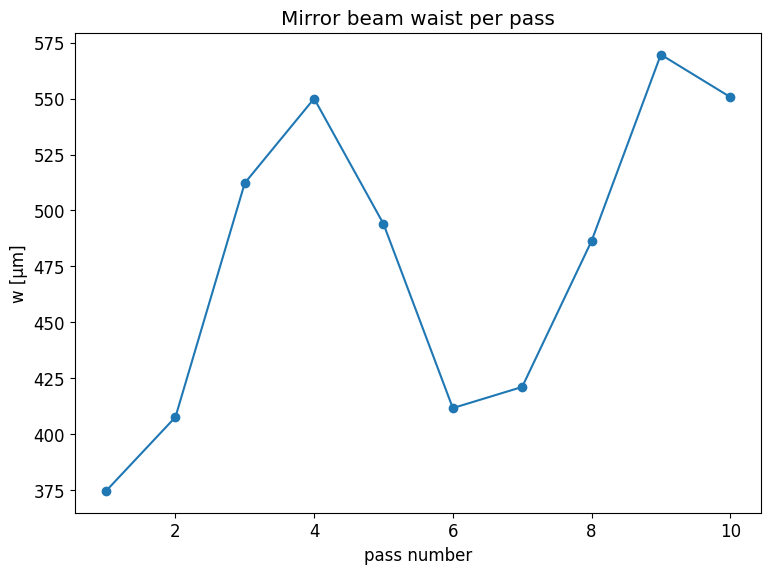

In [67]:
# PLOT mirror beam waist per pass
plt.figure(figsize=size_py) 
plt.title("Mirror beam waist per pass")
plt.plot(1:Npass, w_mirr.*1e6, marker="o")
#plt.xticks(0:5:Npass)
plt.xlabel("pass number")
plt.ylabel("w [μm]")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "beam_waist_mirr.png"), dpi=res) 
end
plt.gcf()

### d) Spectral evolution (vs. λ)

In [68]:
Iωr0 = abs2.(Eωr0)    # convert to intensity
Iλr0 = Iwlfreq.(ω, Iωr0)

1025×201×10 Array{Float64, 3}:
[:, :, 1] =
 0.0         0.0         0.0         …  0.0             0.0
 2.42285e23  8.87438e7   2.94812e7      2.83746e5   94262.0
 3.841e23    2.24058e8   7.44334e7      3.93033e6       1.30568e6
 1.11424e24  2.27938e8   7.57223e7      1.478e7         4.91001e6
 3.17044e23  4.64658e8   1.54362e8      3.13914e7       1.04284e7
 3.61222e21  1.48483e9   4.93268e8   …  4.13695e7       1.37432e7
 5.66595e24  3.47719e9   1.15514e9      3.08305e7       1.02421e7
 2.40838e24  5.50234e9   1.82791e9      9.60035e6       3.18929e6
 1.01322e25  5.57864e9   1.85326e9      1.03827e6       3.44919e5
 1.21127e25  3.98542e9   1.32398e9      4.03064e7       1.339e7
 ⋮                                   ⋱                  ⋮
 9.79627e29  1.33942e17  4.44963e16     3.10068e15      1.03006e15
 9.82561e29  8.90043e16  2.95678e16     3.39465e13      1.12772e13
 9.85525e29  8.10404e16  2.69221e16     2.44185e15      8.11198e14
 9.88518e29  1.09175e17  3.62687e16     8.33821e15  

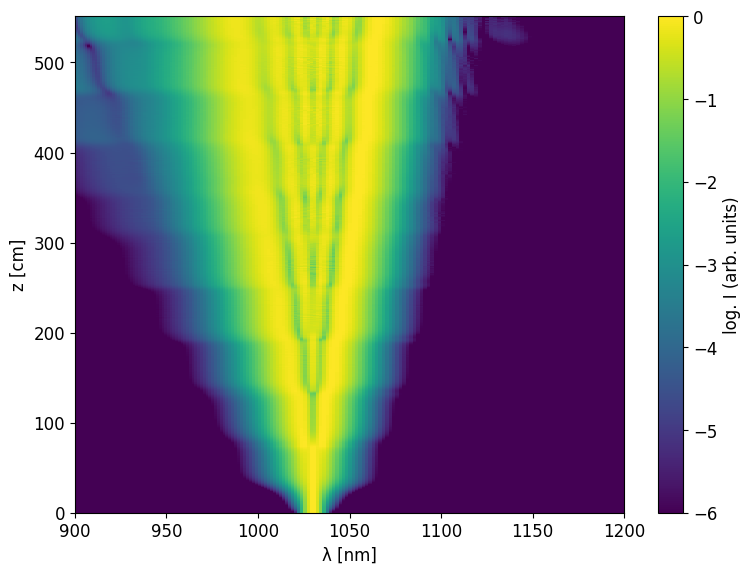

In [69]:
Iλr0_fused = hcat(eachslice(Iλr0, dims=3)...)

#+++++ PLOT 4: spectral evolution (against λ) 
plt.figure(figsize=size_py)
# plt.suptitle("Spectral evolution at r=0")
plt.pcolormesh(λ.*1e9, z_total.*1e2, Maths.log10_norm(transpose(Iλr0_fused[:, :] .+smallval), 2))   
plt.clim(-6, 0)    
plt.colorbar(label="log. I (arb. units)")
plt.xlim(λlims[1]*1e9, λlims[2]*1e9)
# plt.ylim(0,75)
plt.xlabel("λ [nm]")
plt.ylabel("z [cm]")
# plt.xlim(700,1400)
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spectral_evolution_wl.png"), dpi=res) 
end
plt.gcf()


In [70]:
# # Create an animation object
# anim = @animate for i in 1:20:length(z_total)
#     Plots.plot(λ.*1e9, Maths.normbymax(Iλr0_fused[:, i]),
#     # size=size_jl,
#     xlim=(λlims[1]*1e9, λlims[2]*1e9), 
#     ylim=(0, 1), 
#     xlabel=("λ [nm]"),
#     ylabel=("I [norm.]"), 
#     label="z =  $(round(z_total[i]*1e2, digits=1)) cm", 
#     title="Spectral evolution"
#     )
# end

# # Show the animation in the notebook
# gif(anim, joinpath(run_path, "spectral_evolution.gif"), fps=24)

In [71]:
# # Create an animation object
# anim = @animate for i in 1:20:length(z_total)
#     Plots.plot(λ.*1e9, Maths.log10_norm(Iλr0_fused[:, i] .+smallval), 
#     # size=size_jl,
#     xlim=(λlims[1]*1e9, λlims[2]*1e9), 
#     ylim=(-6, 0), 
#     xlabel=("λ [nm]"),
#     ylabel=("log10(I) [norm.]"), 
#     label="z =  $(round(z_total[i]*1e2, digits=1)) cm", 
#     title="Spectral evolution"
#     )
# end

# # Show the animation in the notebook
# gif(anim, joinpath(run_path, "spectral_evolution_log.gif"), fps=24)

### E) Spectral evolution (vs. f)

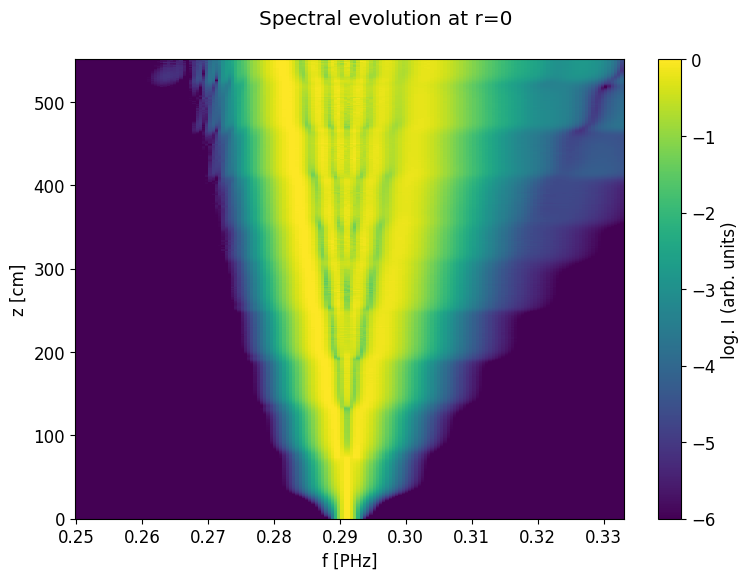

In [72]:
Iωr0_fused = hcat(eachslice(Iωr0, dims=3)...)

#+++++ PLOT 5: spectral evolution (against f) 
plt.figure(figsize=size_py)
plt.suptitle("Spectral evolution at r=0")
plt.pcolormesh(f*1e-15, z_total.*1e2, Maths.log10_norm(transpose(Iωr0_fused[:, :] .+smallval), 2))   
plt.clim(-6, 0)    
plt.colorbar(label="log. I (arb. units)")
plt.xlim(PhysData.wlfreq(λlims[2])/2pi*1e-15, PhysData.wlfreq(λlims[1])/2pi*1e-15)
plt.xlabel("f [PHz]")
plt.ylabel("z [cm]")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spectral_evolution_f.png"), dpi=res) 
end
plt.gcf()

### f) Temporal evolution

In [73]:
Etr0 = zeros((size(Eωr0,1)-1)*2, size(Eωr0,2), size(Eωr0,3))
Itr0 = similar(Etr0)

for pass in 1:size(Eωr0,3)
    Etr0[:,:,pass] = FFTW.irfft(Eωr0[:,:,pass], length(t), 1)  # pulse for r=0
    Itr0[:,:,pass] = abs2.(Maths.hilbert(Etr0[:,:,pass]))           # temporal intensity for r=0
end

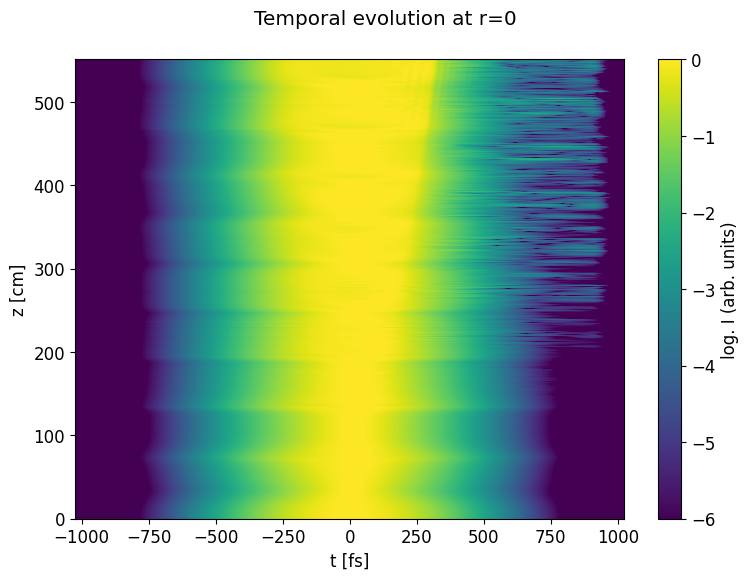

In [74]:
Itr0_fused = hcat(eachslice(Itr0, dims=3)...)

#+++++ PLOT 4: temporal evolution 
plt.figure(figsize=size_py)
plt.suptitle("Temporal evolution at r=0")
plt.pcolormesh(t.*1e15, z_total.*1e2, Maths.log10_norm(transpose(Itr0_fused[:,:] .+smallval), 2))   
plt.clim(-6, 0)    
plt.colorbar(label="log. I (arb. units)")
plt.xlim(minimum(t)*1e15, maximum(t)*1e15)
plt.xlabel("t [fs]")
plt.ylabel("z [cm]")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "temporal_evolution.png"), dpi=res) 
end
plt.gcf()

In [75]:
# # Create an animation object
# anim = @animate for i in 1:20:length(z_total)
#     Plots.plot(t.*1e15, Maths.normbymax(Itr0_fused[:, i]),
#     # size=size_jl,
#     ylim=(0, 1), 
#     xlabel=("t [fs]"),
#     ylabel=("I [norm.]"), 
#     label="z =  $(round(z_total[i]*1e2)) cm", 
#     title="Temporal evolution"
#     )
# end

# # Show the animation in the notebook
# gif(anim, joinpath(run_path, "temporal_evolution.gif"), fps=24)

In [76]:
# # Create an animation object
# anim = @animate for i in 1:20:length(z_total)
#     Plots.plot(t.*1e15, Maths.log10_norm(Itr0_fused[:, i] .+smallval),
#     # size=size_jl,
#     ylim=(-6, 0), 
#     xlabel=("t [fs]"),
#     ylabel=("log10(I) [norm.]"), 
#     label="z =  $(round(z_total[i]*1e2)) cm", 
#     title="Temporal evolution"
#     )
# end

# # Show the animation in the notebook
# gif(anim, joinpath(run_path, "temporal_evolution_log.gif"), fps=24)

## B-Integral

In [77]:
I_peak = dropdims(maximum(Itr0, dims=1), dims=1)

201×10 Matrix{Float64}:
 1.08704e18  2.26441e18  2.19379e18  …  1.206e18    1.00895e18  6.48169e17
 1.10508e18  2.29755e18  2.23982e18     1.22886e18  1.01009e18  6.4711e17
 1.12369e18  2.33117e18  2.28716e18     1.25072e18  1.03835e18  6.45734e17
 1.14285e18  2.36498e18  2.3356e18      1.26989e18  1.06817e18  6.70676e17
 1.16226e18  2.39984e18  2.38595e18     1.29799e18  1.06449e18  6.86225e17
 1.1825e18   2.43625e18  2.43666e18  …  1.3362e18   1.08485e18  6.73934e17
 1.20347e18  2.47209e18  2.48983e18     1.35631e18  1.12375e18  6.76779e17
 1.22501e18  2.50658e18  2.54559e18     1.37355e18  1.14554e18  7.23547e17
 1.24727e18  2.54525e18  2.60494e18     1.41326e18  1.17484e18  7.54636e17
 1.26893e18  2.58463e18  2.65851e18     1.44318e18  1.21415e18  7.35346e17
 ⋮                                   ⋱                          
 2.71623e18  2.50113e18  1.31932e18     1.13007e18  7.27177e17  8.25885e17
 2.65457e18  2.46904e18  1.31444e18     1.13332e18  7.27008e17  7.82926e17
 2.59369e18 

In [78]:
I_peak_fused = dropdims(hcat(I_peak...), dims=1)


2010-element Vector{Float64}:
 1.0870385145576659e18
 1.105075744772681e18
 1.1236890329735354e18
 1.142854521728158e18
 1.162256956590701e18
 1.182500451601712e18
 1.2034747431965883e18
 1.2250084301319985e18
 1.2472665253133804e18
 1.2689250722555395e18
 ⋮
 8.258850987839437e17
 7.829255289343393e17
 7.98208618530295e17
 7.939485646867281e17
 7.689258062864004e17
 7.824564865298144e17
 6.866973984885772e17
 6.836594678446675e17
 6.652518673414267e17

In [79]:
size(z_total)

(2010,)

In [80]:
fac = 1e-4*PhysData.c*PhysData.ε_0/2 # to convert to intensities in W/cm^2

1.3272093647190362e-7

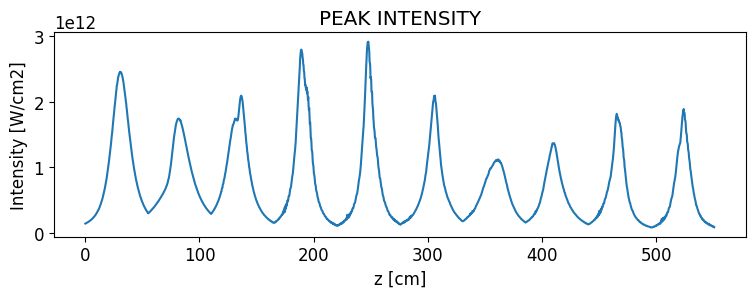

In [81]:
# PLOT PEAK INTENSITY
plt.figure(figsize=size_py_wide) 
plt.title("PEAK INTENSITY")
# plt.plot(z_total.*1e2, cat(dims=1, w_z...).*1e6)
plt.plot(z_total.*1e2, fac.*I_peak_fused)
plt.xlabel("z [cm]")
plt.ylabel("Intensity [W/cm2]")
# plt.ylim(0, 1.2e13)
plt.tight_layout()
if save_figs 
    # plt.savefig(joinpath(run_path, "caustic.png"), dpi=res) 
end
plt.gcf()

In [82]:
# integrate peak intensity over z for each pass
I_peak_int = zeros(size(I_peak,2))
for ii = 1:size(I_peak, 2)
    I_peak_int[ii] = integrate(z, I_peak[:, ii], SimpsonEven());
end

In [83]:
n2 = params["n2"]
B_int = 2pi/λ0*n2*I_peak_int
B_int .*= PhysData.c*PhysData.ε_0/2

10-element Vector{Float64}:
 6.883847496234214
 5.690831118603824
 5.92905590830227
 5.939958375019671
 5.455822904649582
 4.599538856855904
 3.997178063332098
 3.781524858335783
 3.900057376105508
 3.841768109752349

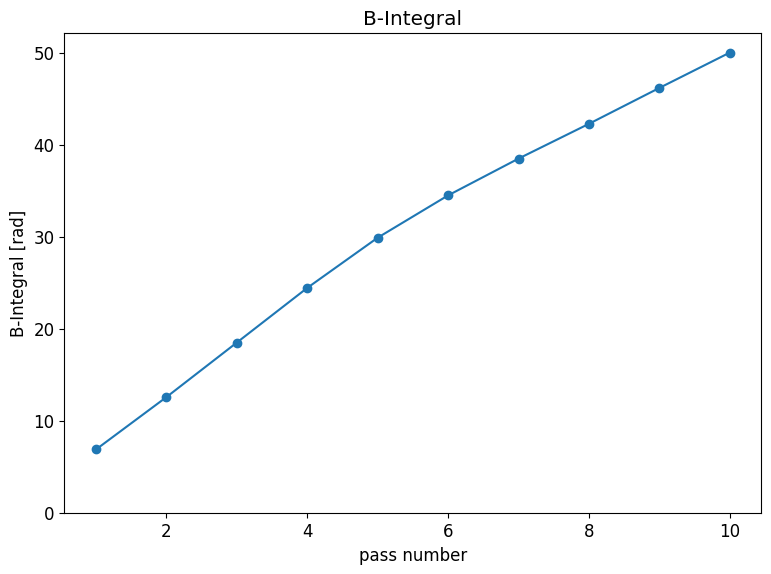

In [84]:
# PLOT B-integral per pass
plt.figure(figsize=size_py) 
plt.title("B-Integral")
plt.plot(1:Npass, cumsum(B_int), marker="o")
#plt.xticks(0:5:Npass)
plt.xlabel("pass number")
plt.ylabel("B-Integral [rad]")
plt.ylim(0,)
plt.tight_layout()
if save_figs 
    # plt.savefig(joinpath(run_path, "beam_waist_mirr.png"), dpi=res) 
end
plt.gcf()

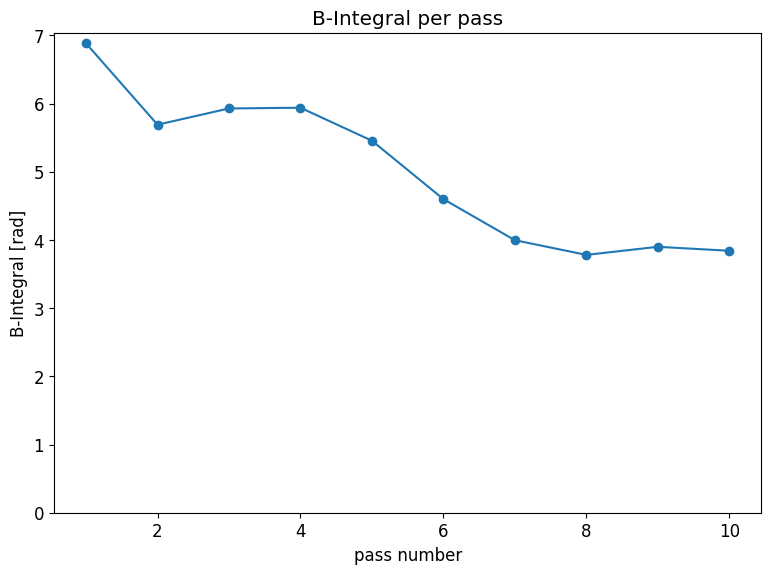

In [85]:
# PLOT B-integral per pass
plt.figure(figsize=size_py) 
plt.title("B-Integral per pass")
plt.plot(1:Npass, B_int, marker="o")
#plt.xticks(0:5:Npass)
plt.xlabel("pass number")
plt.ylabel("B-Integral [rad]")
plt.ylim(0,)
plt.tight_layout()
if save_figs 
    # plt.savefig(joinpath(run_path, "beam_waist_mirr.png"), dpi=res) 
end
plt.gcf()

In [86]:
# Expected accumulated B-Integral based on eq.8 in Viotti et al. 2022
E_pulse = params["E_pulse"]
τ = params["τ"]
k = params["k"]
Nrt = params["Npass"]/2

P_peak = 0.94*E_pulse/τ
B_pass = 4*pi^2*n2*P_peak/λ0^2*(k/Nrt)
B_total = Nrt*B_pass

println("B_pass = ", B_pass)
println("B_total = ", B_total)

B_pass = 2.4284347737935112
B_total = 12.142173868967557
